# Test Skin Lesion prediction

In [29]:
import sys
import warnings
warnings.filterwarnings('ignore')

IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    from google.colab import drive
    drive.mount("/content/gdrive")
    sys.path.insert(0,'/content/gdrive/MyDrive/Colab Notebooks/SkinSegASML/src')
    !pip install comet_ml
else:
    sys.path.insert(0,'/home/shan/Spaces/Personal/SkinSegASML/src')

In [5]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import glob
import matplotlib.pyplot as plt
import cv2
from skinseg.dataset.segmentation_dataset import SegmentationDataset

In [3]:
data_path = "/content/gdrive/MyDrive/data/isic-512"

In [6]:
p = [
    transforms.Compose([transforms.ToTensor(), transforms.Resize((572, 572))]),
    transforms.Compose([transforms.ToTensor(), transforms.Resize((388, 388))]),
]
train_dataset = SegmentationDataset(
    f"{data_path}/resized_train",
    f"{data_path}/resized_train_gt",
    transforms=p,
    cache=True,
)
test_dataset = SegmentationDataset(
    f"{data_path}/resized_test",
    f"{data_path}/resized_test_gt",
    transforms=p,
    cache=True,
)
valid_dataset = SegmentationDataset(
    f"{data_path}/resized_valid",
    f"{data_path}/resized_valid_gt",
    transforms=p,
    cache=True,
)

In [7]:
dataset_labels = ["train", "test", "valid"]

### Set dataloader

In [9]:
if IN_COLAB:
  batch_size = 8 
else:
  batch_size = 2

In [10]:
train_dataloader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)
test_dataloader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)
valid_dataloader = DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, pin_memory=True
)

## Load Unet model

In [11]:
!nvidia-smi

Tue Apr  4 13:24:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA P106-100     Off  | 00000000:02:00.0 Off |                  N/A |
| 49%   56C    P0    28W / 120W |      0MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
checkpoints_path = "/content/gdrive/MyDrive/data/unet_isic_chkpt/"

In [13]:
!ls -alh $checkpoints_path | head

total 36G
drwxr-xr-x 2 shan shan 4.0K Apr  2 11:41 .
drwxr-xr-x 7 shan shan 4.0K Apr  4 11:06 ..
-rw-rw-r-- 1 shan shan 107M Mar 31 20:49 unet-epoch-0.pt
-rw-rw-r-- 1 shan shan 107M Apr  2 09:40 unet-epoch-100.pt
-rw-rw-r-- 1 shan shan 107M Apr  1 11:50 unet-epoch-10.pt
-rw-rw-r-- 1 shan shan 107M Apr  2 11:41 unet-epoch-110.pt
-rw-rw-r-- 1 shan shan 107M Apr  1 13:49 unet-epoch-20.pt
-rw-rw-r-- 1 shan shan 107M Apr  1 15:49 unet-epoch-30.pt
-rw-rw-r-- 1 shan shan 107M Apr  1 17:48 unet-epoch-40.pt


In [14]:
from skinseg.model.lesion_unet import Unet, compute_iou, iou_per_volume, JaccardLoss
from skinseg.model.lesion_unet import evaluate_segmentation_result, compute_total_loss

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = Unet()
unet.to(device)
iou_loss = JaccardLoss("binary")

In [16]:
# Model class must be defined somewhere
epoch_to_load = 0
checkpoint = torch.load(f'{checkpoints_path}/unet-epoch-{epoch_to_load}.pt')
unet.load_state_dict(checkpoint)
#unet.eval()

<All keys matched successfully>

In [17]:
#epoch_to_load = 99
#checkpoint = torch.load(f'{checkpoints_path}/unet-epoch-train-{epoch_to_load}.pt')
#unet.load_state_dict(checkpoint['model_state_dict'])
#optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#start_epoch = checkpoint['epoch'] + 1
#loss_train = checkpoint['loss']
#unet.eval()

## Test segmentation result

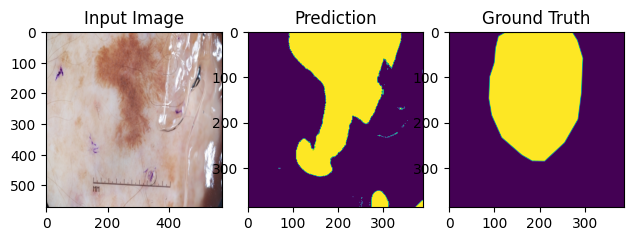

IoU ( Intersection over Union )
0.6794708190522083


In [18]:
evaluate_segmentation_result(unet, device, test_dataset[58])

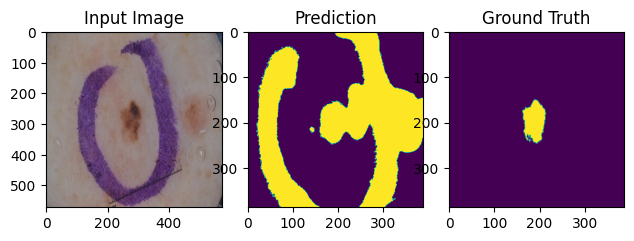

IoU ( Intersection over Union )
0.33880801939686406


In [19]:
evaluate_segmentation_result(unet, device, test_dataset[100])

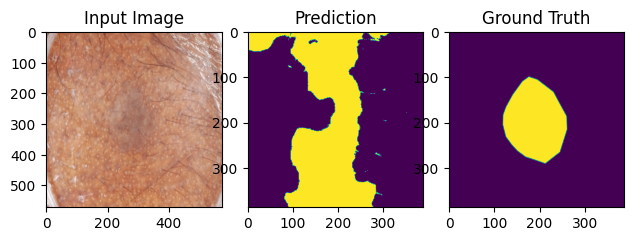

IoU ( Intersection over Union )
0.4583009103282632


In [20]:
evaluate_segmentation_result(unet, device, test_dataset[10])

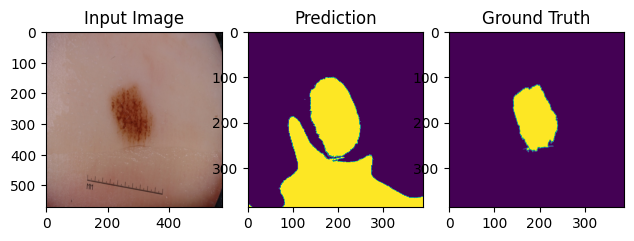

IoU ( Intersection over Union )
0.5051897530388708


In [21]:
evaluate_segmentation_result(unet, device, test_dataset[50])

## Total loss

In [22]:
compute_total_loss(unet, device, iou_loss, test_dataloader)

test loss :  0.6488221818208695
test iou :  0.5245944315731289


### Well trained model

In [23]:
# Model class must be defined somewhere
epoch_to_load = 110
checkpoint = torch.load(f'{checkpoints_path}/unet-epoch-{epoch_to_load}.pt')
unet.load_state_dict(checkpoint)
#unet.eval()

<All keys matched successfully>

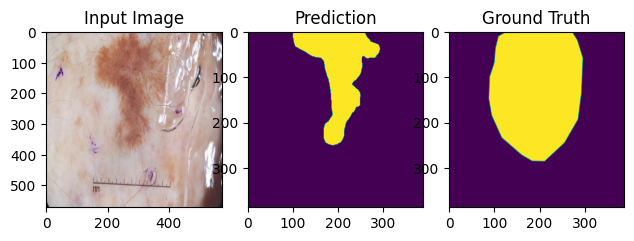

IoU ( Intersection over Union )
0.5911276206963059


In [24]:
evaluate_segmentation_result(unet, device, test_dataset[58])

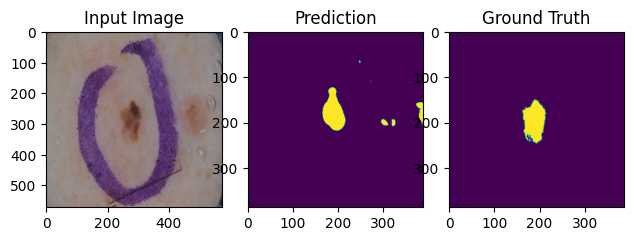

IoU ( Intersection over Union )
0.7187294814279012


In [25]:
evaluate_segmentation_result(unet, device, test_dataset[100])

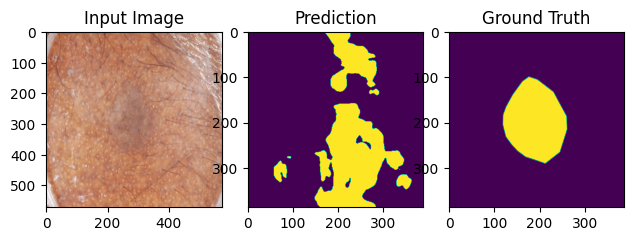

IoU ( Intersection over Union )
0.4695613928679743


In [26]:
evaluate_segmentation_result(unet, device, test_dataset[10])

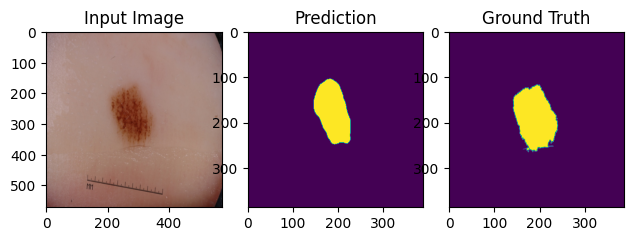

IoU ( Intersection over Union )
0.8405850870007079


In [27]:
evaluate_segmentation_result(unet, device, test_dataset[50])

## Total loss


In [28]:
compute_total_loss(unet, device, iou_loss, test_dataloader)

test loss :  0.46007272879282635
test iou :  0.695022855557401
